In [24]:
import os
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn import metrics
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB

# Data Analysis

In [25]:
df = pd.read_csv("data.csv")

In [26]:
df.head()

,Unnamed: 0,tweets,target
0,0,Pete Buttigieg Admits Only Recently Realizing ...,1
1,1,Mom Changes Words Of Prayer To Be More Cheerful,1
2,2,Macy’s Parade Float Covered In Tickets After P...,1
3,3,Winter Storms Threaten Americans Traveling Bac...,1
4,4,White House Begins Christmas Season With Cerem...,1


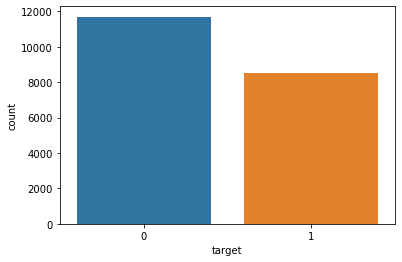

In [27]:
sns.countplot(x = 'target', data = df)

In [28]:
df['Tweets_length'] = df['tweets'].str.len()
#drop null values
df = df.dropna(subset=['tweets'])

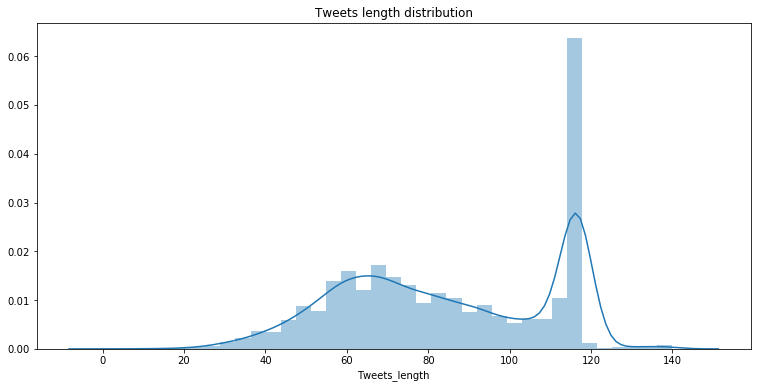

In [29]:
plt.figure(figsize=(12.8,6))
sns.distplot(df['Tweets_length']).set_title('Tweets length distribution');

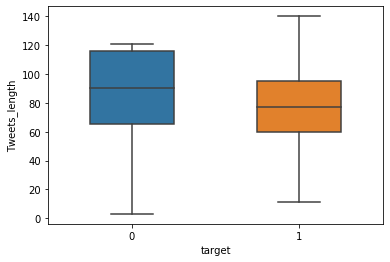

In [30]:
sns.boxplot(data=df, x='target', y='Tweets_length', width=.5);

(-0.5, 399.5, 199.5, -0.5)

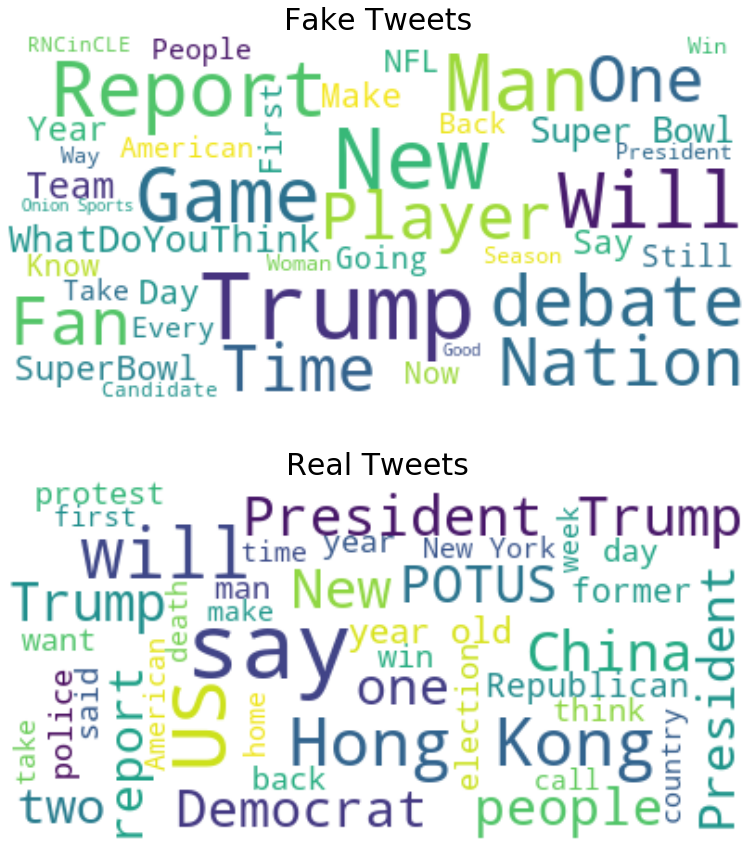

In [35]:
from wordcloud import WordCloud 
df_fake = df[df['target']==1]
df_real = df[df['target']==0]
tweet_fake = " ".join(review for review in df_fake.tweets)
tweet_real = " ".join(review for review in df_real.tweets)
fig, ax = plt.subplots(2, 1, figsize  = (15,15))
wordcloud_fake = WordCloud(max_font_size=50, max_words=40, background_color="white").generate(tweet_fake)
wordcloud_real = WordCloud(max_font_size=50, max_words=40, background_color="white").generate(tweet_real)
# Display the generated image:
ax[0].imshow(wordcloud_fake, interpolation='bilinear')
ax[0].set_title('Fake Tweets', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_real, interpolation='bilinear')
ax[1].set_title('Real Tweets',fontsize=30)
ax[1].axis('off')

# Feature Engineering

## Text cleaning and preparation

In [36]:
# Downloading the stop words list
nltk.download('stopwords')

# Loading the stop words in english
stopword = nltk.corpus.stopwords.words('english')

def create_features_from_df(df):
    
    def remove_punct(text):
      text  = "".join([char for char in text if char not in string.punctuation])
      return text

    def clean_text(text):
      txt = re.sub("[( ' )( ')(' )]", ' ', text)
      txt=re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) | (\w +:\ / \ / \S +)", " ", txt)
      return txt.lower()

    def remove_stopwords(text):
      text  = " ".join([word for word in text.split(" ") if word not in stopword])
      return text

    df['new_tweets'] = df['tweets'].apply(lambda x: remove_punct(str(x)))
    df['new_tweets'] = df['new_tweets'].apply(lambda x: clean_text(str(x)))
    df['new_tweets'] = df['new_tweets'].apply(lambda x: remove_stopwords(str(x)))
    df.dropna()
    return df

[nltk_data] Downloading package stopwords to C:\Users\kon-
[nltk_data]     boot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
df.to_csv("Cleaned_Tweets.csv")

# Comparing Fake News Classifiers

##Transforming our collected data

In [40]:
# Load data
df = pd.read_csv("Cleaned_Tweets.csv")

In [41]:
df=df.dropna(how='any')

In [42]:
df.head()

,Unnamed: 0,Unnamed: 0.1,tweets,target,Tweets_length
0,0,0,Pete Buttigieg Admits Only Recently Realizing ...,1,69.0
1,1,1,Mom Changes Words Of Prayer To Be More Cheerful,1,49.0
2,2,2,Macy’s Parade Float Covered In Tickets After P...,1,89.0
3,3,3,Winter Storms Threaten Americans Traveling Bac...,1,84.0
4,4,4,White House Begins Christmas Season With Cerem...,1,71.0


In [43]:
y = df.target
df = df.drop('target', axis=1)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df['tweets'], y, test_size=0.33, random_state=53)

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

##Training models

### PassiveAggressiveClassifier

In [48]:
pa_tfidf_clf = PassiveAggressiveClassifier(50)
pa_tfidf_clf.fit(tfidf_train, y_train)
pred = pa_tfidf_clf.predict(tfidf_test)

In [49]:
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.907


### MultinomialNB

In [50]:
mn_tfidf_clf = MultinomialNB(alpha=0.1)
mn_tfidf_clf.fit(tfidf_train, y_train)
pred = mn_tfidf_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.906


### LinearSVC

In [51]:
from sklearn.svm import LinearSVC
svc_tfidf_clf = LinearSVC()

svc_tfidf_clf.fit(tfidf_train, y_train)
pred = svc_tfidf_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.915


### ROC_curve

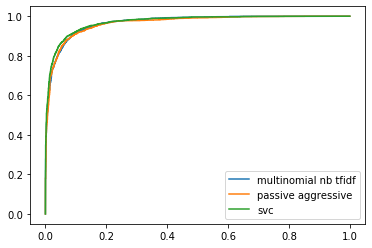

In [52]:
plt.figure(0).clf()

for model, name in [ (mn_tfidf_clf, 'multinomial nb tfidf'),
                     (pa_tfidf_clf, 'passive aggressive'),
                     (svc_tfidf_clf, 'svc')]:
    if 'multinomial' in name:
        pred = model.predict_proba(tfidf_test)[:,1]
    else: 
        pred = model.decision_function(tfidf_test)
    fpr, tpr, thresh = metrics.roc_curve(y_test.values, pred)
    plt.plot(fpr,tpr,label="{}".format(name))

plt.legend(loc=0)

# Saving model and functions

In [54]:
import pickle
#save tfidf to the disk
filename = 'cleaning_data.sav'
pickle.dump(create_features_from_df, open(filename, 'wb'))
# save the model to disk
filename = 'svc_model.sav'
pickle.dump(svc_tfidf_clf, open(filename, 'wb'))
#save tfidf vectorizer
filename = 'tfidf_vectorizer.sav'
pickle.dump(tfidf_vectorizer, open(filename, 'wb'))

#Introspecting models

In [55]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    return {class_labels[0]: topn_class1,
            class_labels[1]: topn_class2
    }

most_informative_feature_for_binary_classification(tfidf_vectorizer, pa_tfidf_clf, n=10)

{0: [(-5.235729396313162, 'potus'),
  (-4.573723102685782, 'roundup'),
  (-4.212443284575174, 'rep'),
  (-4.058194526182946, 'canada'),
  (-3.9452721204786125, 'japan'),
  (-3.7887029265727654, 'south'),
  (-3.7838483592654257, 'according'),
  (-3.78018605591506, 'india'),
  (-3.6917034148265064, 'probe'),
  (-3.527066866246256, 'uk')],
 1: [(3.8393483107355575, 'debates'),
  (4.393870383427608, 'horoscopes'),
  (4.422204380834332, 'primer'),
  (4.462787632754164, 'jointaddress'),
  (4.572284221089302, 'superbowl'),
  (4.655192377578799, 'fucking'),
  (4.96477799421056, 'sotu'),
  (5.168521812289179, 'rncincle'),
  (6.2674539772661575, 'demsinphilly'),
  (9.333915323993345, 'whatdoyouthink')]}

In [56]:
classifiers = [(mn_tfidf_clf, tfidf_vectorizer),
               (pa_tfidf_clf, tfidf_vectorizer),
               (svc_tfidf_clf, tfidf_vectorizer)]

In [57]:
results = {}
for clf, vct in classifiers:
    results[clf] = most_informative_feature_for_binary_classification(vct, clf, n=10)

In [58]:
comparable_results = {0: {}, 1: {}}
for clf, data in results.items():
    clf_name = clf.__class__.__name__
    for label, features in data.items():
        for rank, score_tuple in enumerate(features):
            if score_tuple[1] in comparable_results[label]:
                comparable_results[label][score_tuple[1]].append((rank + 1, clf_name))
            else:
                comparable_results[label][score_tuple[1]] = [(rank + 1, clf_name)]

In [60]:
import numpy as np
agg_results = {}
for label, features in comparable_results.items():
    for feature, ranks in features.items():
        if feature in agg_results:
            print("WARNING! DUPLICATE LABEL!!! {}".format(feature))
        agg_results[feature] = {
            'label': label,
            'agg_rank': np.mean([r[0] for r in ranks]),
            'count': len(ranks)
        }

In [61]:
comparison_df = pd.DataFrame(agg_results).T

In [62]:
comparison_df[comparison_df['label'] == 0].sort_values('count', ascending=0).head(10)

,label,agg_rank,count
canada,0.0,6.5,2.0
india,0.0,7.5,2.0
south,0.0,5.5,2.0
potus,0.0,1.0,2.0
roundup,0.0,2.0,2.0
japan,0.0,4.5,2.0
000kg,0.0,1.0,1.0
midterm,0.0,8.0,1.0
president,0.0,6.0,1.0
china,0.0,3.0,1.0


In [63]:
comparison_df[comparison_df['label'] == 1].sort_values('count', ascending=0).head(10)

,label,agg_rank,count
demsinphilly,1.0,7.666667,3.0
nation,1.0,2.500000,2.0
horoscopes,1.0,2.000000,2.0
whatdoyouthink,1.0,10.000000,2.0
rncincle,1.0,8.000000,2.0
sotu,1.0,7.000000,2.0
fucking,1.0,4.500000,2.0
superbowl,1.0,5.000000,2.0
jointaddress,1.0,5.000000,2.0
primer,1.0,3.000000,1.0


# Tweets Classification

In [65]:
# load 
svc_model = pickle.load(open("svc_model.sav", 'rb'))
cleaning_data = pickle.load(open("cleaning_data.sav", 'rb'))
tfidf_vectorizer= pickle.load(open("tfidf_vectorizer.sav", 'rb'))

In [67]:
tfidf_vectorizer= pickle.load(open("tfidf_vectorizer.sav", 'rb'))

In [68]:
category_codes = {
    'Real': 0,
    'Fake': 1
}

In [69]:
# Tweets scraping
import tweepy
def get_tweets():
    #Twitter API credentials
    consumer_key = "tiVIII7j3O9bPAbRgdJWmoJWd"
    consumer_secret = "SR5KZuyzFgXkXvd0tADD8qFDfYzQ0mXBaTTvgDq0SagnHlWLEU"
    access_token = "490394724-yTbJ770PfbqAqdiejo8IfEEKkIKTTtmTNodZI0ru"
    access_token_secret = "3qouPTCCnp6t1tfV6NjcXbJ4ulQ4wJ5WQt9QZzwURuTGo"
    
    OAUTH_KEYS = {'consumer_key':consumer_key, 'consumer_secret':consumer_secret,
    'access_token_key':access_token, 'access_token_secret':access_token_secret}
    auth = tweepy.OAuthHandler(OAUTH_KEYS['consumer_key'], OAUTH_KEYS['consumer_secret'])
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

    # Request
    search = tweepy.Cursor(api.search, q='Trump').items(60)

    # Creation des listes pour chaque tweet
    sn = []
    text = []
    timestamp =[]
    for tweet in search:
        sn.append(tweet.user.screen_name)
        text.append(tweet.text)
        
    # df_features
    df_features = pd.DataFrame(
         {'tweets': text 
        })
    # df_show_info

    df_show_info = pd.DataFrame(

        {'User Screen Name': sn
        })
    
    return (df_features,df_show_info)

In [70]:
def get_category_name(category_id):
    for category, id_ in category_codes.items():    
        if id_ == category_id:
            return category

In [71]:
def predict_from_features(features):
        
    predictions_pre = svc_model.predict(features)

    predictions = []

    for cat in predictions_pre:
           predictions.append(cat)

    categories = [get_category_name(x) for x in predictions]
    
    return categories

In [72]:
def complete_df(df, categories):
    df['Prediction'] = categories
    return df

In [73]:
(df_features,df_show_info) = get_tweets()

In [74]:
df_features = cleaning_data(df_features)

In [75]:
features = tfidf_vectorizer.transform(df_features['new_tweets']).toarray()

In [76]:
predictions = predict_from_features(features)

In [77]:
df = complete_df(df_show_info, predictions)

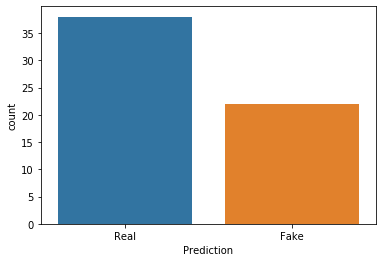

In [78]:
sns.countplot(x = 'Prediction', data = df)